In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 200, canonicalize_fmap=None
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 200, canonicalize_fmap=None
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.73it/s]


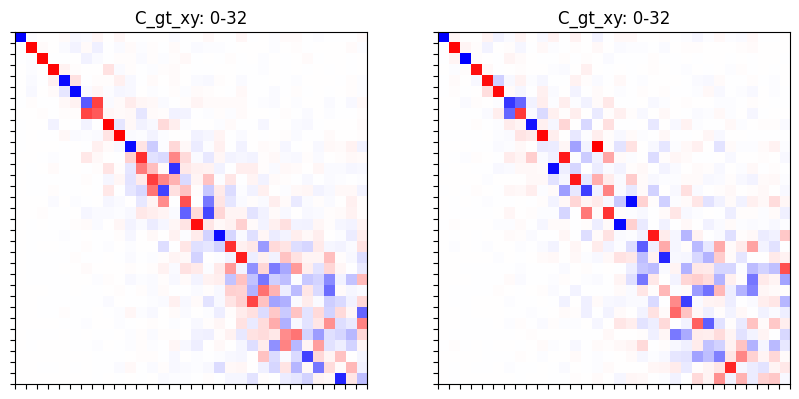

In [3]:
import my_code.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], test_dataset[1]['second']['C_gt_xy'][0],
                        'C_gt_xy', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [51]:
def predict_support_vector(net, verts, faces, evecs_flip, evecs_cond):
    
    # normalize the evecs
    evecs_flip = torch.nn.functional.normalize(evecs_flip, p=2, dim=1)
    
    if evecs_cond is not None:
        evecs_cond = torch.nn.functional.normalize(evecs_cond, p=2, dim=1)
        evecs_input = torch.cat([evecs_flip, evecs_cond], dim=-1)
    else:
        evecs_input = evecs_flip
        
    # process the flipped evecs
    support_vector_flip = net(
        verts=verts,
        faces=faces,
        feats=evecs_input,
    ) # [1 x 6890 x 1]

    # normalize the support vector
    support_vector_norm = torch.nn.functional.normalize(support_vector_flip, p=2, dim=1)
    
    # multiply the support vector by the flipped evecs [1 x 6890 x 4].T @ [1 x 6890 x 4]
    product_with_support = support_vector_norm.transpose(1, 2) @ evecs_flip
    
    return product_with_support, support_vector_norm
    
    # product_with_support = support_vector_flip.transpose(1, 2) @ evecs_flip
    
    # return product_with_support, None

In [52]:
import networks.diffusion_network as diffusion_network

condition_dim = 0
start_dim = 0
feature_dim = 8

# band_size = 8

# mask = torch.zeros(feature_dim, feature_dim).to(device)
# for i in range(feature_dim):
#     for j in range(feature_dim):
#         if abs(i - j) < band_size:
#             mask[i, j] = 1
           
           

# tau = 0.1 # Temperature parameter.
# n_sink_iter = 40 # Number of iterations of Sinkhorn operator.


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = diffusion_network.DiffusionNet(
    in_channels=feature_dim + condition_dim,
    out_channels=feature_dim,
    # hidden_channels=feature_dim // 2,
    cache_dir=f'data_with_smpl_corr/FAUST_original/{200}',
    input_type='wks',
    ).to(device)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)


loss=0.0462:  10%|███████▍                                                                   | 3000/30001 [01:45<16:06, 27.94it/s]

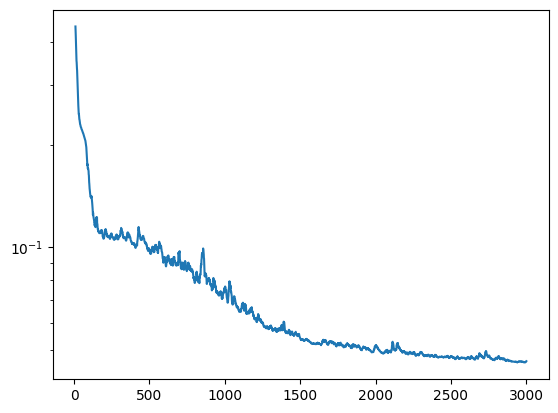

loss=0.0442:  20%|██████████████▉                                                            | 6000/30001 [03:31<13:43, 29.15it/s]

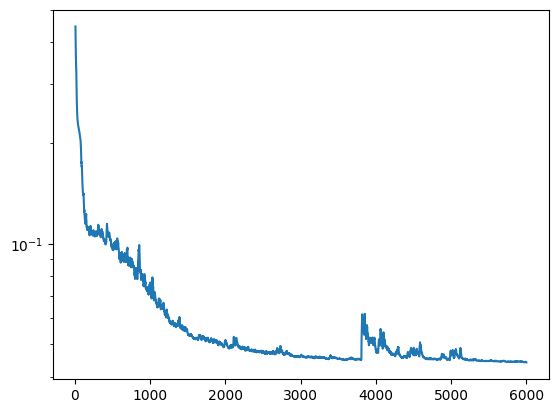

loss=0.0427:  30%|██████████████████████▍                                                    | 9000/30001 [05:14<11:57, 29.28it/s]

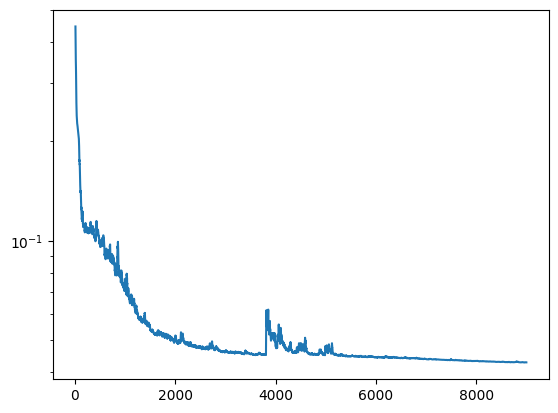

loss=0.0430:  40%|█████████████████████████████▌                                            | 12000/30001 [06:59<10:21, 28.99it/s]

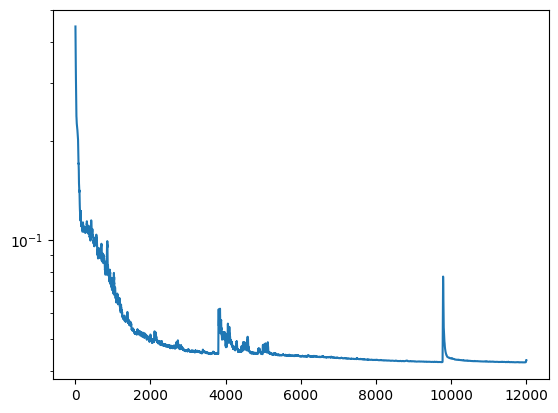

loss=0.0424:  50%|████████████████████████████████████▉                                     | 15000/30001 [08:45<08:59, 27.83it/s]

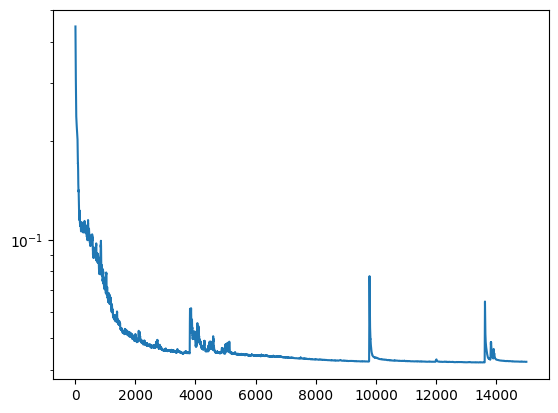

loss=0.0420:  60%|████████████████████████████████████████████▍                             | 18000/30001 [10:33<07:09, 27.92it/s]

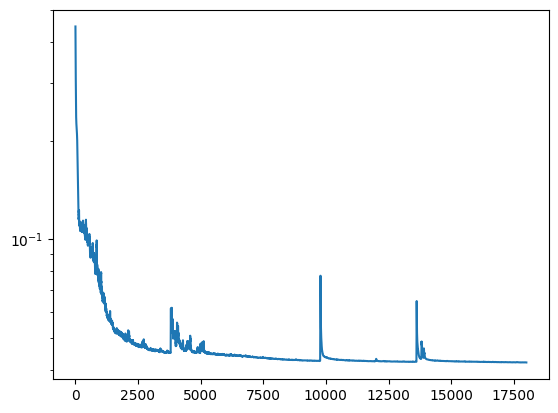

loss=0.0422:  70%|███████████████████████████████████████████████████▊                      | 21000/30001 [12:21<05:23, 27.86it/s]

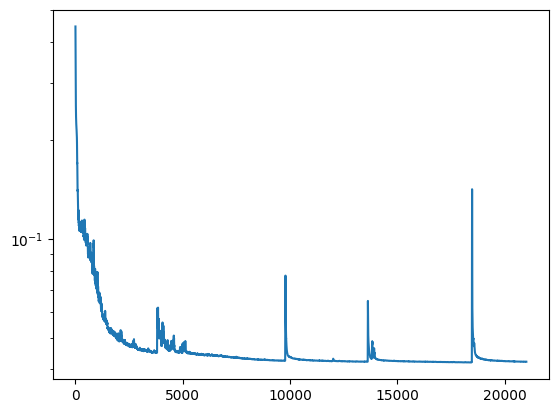

loss=0.0420:  80%|███████████████████████████████████████████████████████████▏              | 24000/30001 [14:07<03:24, 29.29it/s]

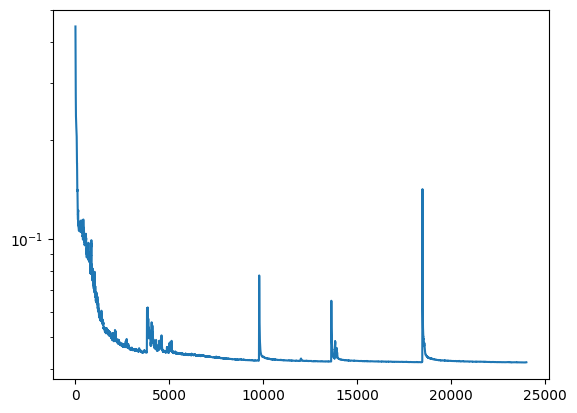

loss=0.0476:  90%|██████████████████████████████████████████████████████████████████▌       | 27000/30001 [15:53<01:45, 28.40it/s]

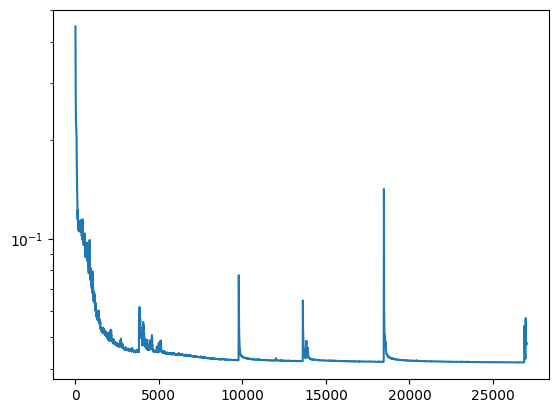

loss=0.0419: 100%|█████████████████████████████████████████████████████████████████████████▉| 30000/30001 [17:38<00:00, 27.72it/s]

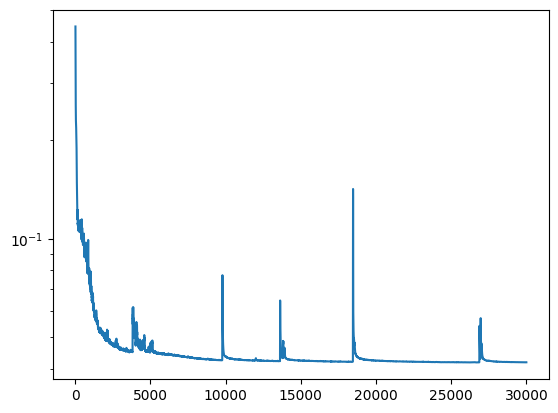

loss=0.0419: 100%|██████████████████████████████████████████████████████████████████████████| 30001/30001 [17:39<00:00, 28.33it/s]


In [53]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import my_code.permutation_utils as permutation_utils


loss_fn = torch.nn.MSELoss(reduction='mean')
losses = torch.tensor([])
iterator = tqdm(range(30001))

# possible_shapes = [train_dataset[i]['second'] for i in range(len(train_dataset))]
possible_shapes = [train_dataset[i]['second'] for i in range(1)]
                   
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    curr_idx = np.random.randint(0, len(possible_shapes))
    
    train_shape = possible_shapes[curr_idx]

    verts = train_shape['verts'].unsqueeze(0).to(device)
    faces = train_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = train_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    
    evecs_orig = evecs_orig.abs()
    ##############################################
    # Set the permutation
    ##############################################

    # create a random permutation matrix
    perm_gt = torch.eye(feature_dim).to(device)
    perm_gt = perm_gt[torch.randperm(perm_gt.shape[0])]
    
    # while True:
    #     perm_gt = torch.eye(feature_dim, device=device)
    #     perm_gt = perm_gt[torch.randperm(perm_gt.shape[0])]
    #     if torch.allclose(perm_gt * mask, perm_gt):
    #         perm_gt = perm_gt.to(device)
    #         break
        
    
    
    # permute the evecs
    evecs_perm = evecs_orig @ perm_gt
    
    ##############################################
    # predict the permutation
    ##############################################
    
    product_with_support, _ = predict_support_vector(
        net, verts, faces, evecs_perm, evecs_cond=None)
    
    
    # perm_pred = product_with_support.abs().log()
    # perm_pred = product_with_support.squeeze(0).abs()
    
    
    
    # print('evecs_orig', evecs_orig.shape, evecs_orig)
    # print('perm_gt', perm_gt.shape, perm_gt)
    # print('evecs_perm', evecs_perm.shape, evecs_perm)
    # print('product_with_support', product_with_support.shape, product_with_support)
    # print('perm_pred', perm_pred.shape, perm_pred)
    
    # break
    
    
    
    # perm_mat_pred = permutation_utils.gumbel_sinkhorn(perm_pred, tau=tau, n_iter=n_sink_iter)
    
    
    # ordered_evecs = evecs_perm @ perm_mat_pred
    
    # print('perm_pred', perm_pred.shape, perm_pred)
    # print('perm_mat_pred', perm_mat_pred.shape, perm_mat_pred)
    
    # print('evecs_perm', evecs_perm.shape, evecs_perm)
    # print('ordered_evecs', ordered_evecs.shape, ordered_evecs)

    # break

    # loss = loss_fn(
    #     ordered_evecs.reshape(ordered_evecs.shape[0], -1),
    #     evecs_orig.reshape(evecs_orig.shape[0], -1)
    #     )
    
    # print(loss_fn(ordered_evecs, evecs_orig))
    # print(loss_fn(evecs_perm @ perm_gt.T, evecs_orig))
     
    perm_pred = product_with_support.squeeze(0)
    
    # print('perm_pred', perm_pred.shape, perm_pred)
    
    # apply mask
    # perm_pred = perm_pred * mask
    
    # print('perm_pred_masked', perm_pred.shape, perm_pred)
    # print('perm_gt', perm_gt.shape, perm_gt)
    # print('mask', mask.shape, mask)
    
    # break
    
    
    # perm_sinkhorn = permutation_utils.log_sinkhorn(torch.log(perm_pred), n_iter=20)

    
    # apply a loss between two permutations, [1 x 4 x 4] and [1 x 4 x 4]
    # loss = torch.nn.functional.binary_cross_entropy(
    #     perm_pred.reshape(perm_pred.shape[0], -1),
    #     perm_gt.reshape(perm_gt.shape[0], -1)
    #     )
    
    # ordered_evecs = evecs_perm @ perm_pred
    
    # loss = loss_fn(
    #     ordered_evecs,
    #     evecs_orig
    #     )
     
    # calculate the loss
    loss = loss_fn(
        perm_gt,
        perm_pred
        )
    
    # loss = loss_fn(
    #     perm_gt,
    #     perm_sinkhorn
    #     )

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses = torch.cat([losses, torch.tensor([loss.item()])])
    
    # print mean of last 10 losses
    iterator.set_description(f'loss={torch.mean(losses[-10:]):.4f}')
    
    # plot the losses every 1000 iterations
    if i > 0 and i % (len(iterator) // 10) == 0:
        # plot the last 10-window mean  of len(iterator) // 10 losses
        pd.Series(losses[-len(iterator) // 10:].numpy()).rolling(window=10).mean().plot()
        # pd.Series(losses.numpy()).rolling(10).mean().plot()
        
        plt.yscale('log')
        plt.show()


In [82]:
test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]
# test_shapes_list = [train_dataset[i]['second'] for i in range(1)]
                   
iterator = tqdm(range(1001))

incorrect_pred_list = torch.tensor([])
for i in iterator:

    ##############################################
    # Select a shape
    ##############################################
    # test_shape = test_shapes_list[i]
    
    curr_idx = np.random.randint(0, len(test_shapes_list))   
    test_shape = test_shapes_list[curr_idx]    

    verts = test_shape['verts'].unsqueeze(0).to(device)
    faces = test_shape['faces'].unsqueeze(0).to(device)

    evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
    # evecs_cond = test_shape['evecs'][:,
    #     start_dim + feature_dim : start_dim + feature_dim + condition_dim].unsqueeze(0).to(device)

    evecs_orig = evecs_orig.abs()

    ##############################################
    # Set the permutation
    ##############################################

    # create a random permutation matrix
    perm_gt = torch.eye(feature_dim).to(device)
    perm_gt = perm_gt[torch.randperm(perm_gt.shape[0])]
    
    # permute the evecs
    evecs_perm = evecs_orig @ perm_gt
    
    ##############################################
    # predict the permutation
    ##############################################
    
    with torch.no_grad():
        product_with_support, _ = predict_support_vector(
            net, verts, faces, evecs_perm, evecs_cond=None)
    
    perm_prob_pred = product_with_support.squeeze(0).abs().cpu()
    
    # perm_prob_pred = perm_prob_pred * mask.cpu()
    
    perm_gt = perm_gt.cpu()
        
        
    # print('perm_gt', perm_gt)
    # print('perm_pred', perm_pred)
    
    
    perm_prob_pred_norm = permutation_utils.log_sinkhorn(torch.log(perm_prob_pred), n_iter=20)
    perm_mat_pred = permutation_utils.matching(perm_prob_pred_norm)
        
    correct_pred = torch.sum(perm_mat_pred * perm_gt)
    incorrect_pred = torch.sum(perm_mat_pred * (1 - perm_gt))
        
        
    # sign_correct = sign_flip_predicted.sign() * sign_flip_gt.sign()
    
    # # count the number of incorrect signs
    # count_incorrect_signs = (sign_correct < 0).int().sum()
    # # incorrect_signs_list.append(count_incorrect_signs)
    incorrect_pred_list = torch.cat([incorrect_pred_list, torch.tensor([incorrect_pred])])
    
    
    iterator.set_description(f'Mean incorrect signs {incorrect_pred_list.float().mean():.2f} / {feature_dim}')
    
    
print(f'Results for {len(incorrect_pred_list)} test shapes')
print(f'Incorrect signs per shape: {incorrect_pred_list.float().mean():.2f} / {feature_dim}')

# print('Shape idx', curr_idx)
print('GT', perm_gt)
print('PRED prob', perm_prob_pred)
print('PRED mat', perm_mat_pred)
print('Correct', correct_pred.item())
print(f'Incorrect signs {incorrect_pred} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


Mean incorrect signs 0.75 / 8: 100%|██████████████████████████████████████████████████████████| 1001/1001 [00:24<00:00, 41.08it/s]

Results for 1001 test shapes
Incorrect signs per shape: 0.75 / 8
GT tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.]])
PRED prob tensor([[0.0351, 0.1170, 0.2357, 0.1204, 0.0355, 0.2347, 0.5339, 0.1234],
        [0.2056, 0.0594, 0.3545, 0.1752, 0.1422, 0.1232, 0.1806, 0.0534],
        [0.6400, 0.0089, 0.0153, 0.2297, 0.1254, 0.1864, 0.1358, 0.2159],
        [0.0890, 0.3175, 0.1113, 0.0763, 0.5385, 0.2270, 0.0646, 0.1117],
        [0.0762, 0.5150, 0.2428, 0.3710, 0.3764, 0.1962, 0.1157, 0.0801],
        [0.0433, 0.0256, 0.0180, 0.4191, 0.1877, 0.2331, 0.0474, 0.1972],
        [0.4853, 0.2173, 0.2866, 0.2240, 0.0865, 0.3102, 0.2969, 0.6855],
        [0.5231, 0.1075, 0.1178, 0.0335, 0.0379, 0.1460, 0.0746, 0.

In [130]:
test_shapes_list = [test_dataset[i]['second'] for i in range(len(test_dataset))]

##############################################
# Select a shape
##############################################
test_shape = test_shapes_list[2]
  
verts = test_shape['verts'].unsqueeze(0).to(device)
faces = test_shape['faces'].unsqueeze(0).to(device)

evecs_orig = test_shape['evecs'][:, start_dim:start_dim+feature_dim].unsqueeze(0).to(device)
evecs_orig = evecs_orig.abs()

##############################################
# Set the permutation
##############################################

# create a random permutation matrix
# perm_gt = torch.eye(feature_dim).to(device)
# perm_gt = perm_gt[torch.randperm(perm_gt.shape[0])]

perm_gt = torch.eye(feature_dim).to(device)

# reorder the last 2 elements
perm_gt[[6, 3]] = perm_gt[[3, 6]]

# permute the evecs
evecs_perm = evecs_orig @ perm_gt

##############################################
# predict the permutation
##############################################

with torch.no_grad():
    product_with_support, support_vectors = predict_support_vector(
        net, verts, faces, evecs_perm, evecs_cond=None)

perm_prob_pred = product_with_support.squeeze(0).abs().cpu()

perm_prob_pred_norm = permutation_utils.log_sinkhorn(torch.log(perm_prob_pred), n_iter=20)
perm_mat_pred = permutation_utils.matching(perm_prob_pred_norm)
    
perm_gt = perm_gt.cpu()
    
correct_pred = torch.sum(perm_mat_pred * perm_gt)
incorrect_pred = torch.sum(perm_mat_pred * (1 - perm_gt))


# print('Shape idx', curr_idx)
print('GT\n', perm_gt, sep='')
print('PRED prob\n', perm_prob_pred, sep='')
print('PRED mat\n', perm_mat_pred, sep='')
print('Correct', correct_pred.item())
print(f'Incorrect signs {incorrect_pred} / {feature_dim}')

# plt.plot(support_vector_norm.squeeze().detach().cpu().numpy(), '.', alpha=0.1)
# plt.ylim(-0.1, 0.1)
# # plt.yscale('log')
# plt.show()


GT
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])
PRED prob
tensor([[0.5264, 0.2315, 0.0390, 0.0503, 0.0817, 0.1743, 0.0209, 0.2477],
        [0.0946, 0.2774, 0.0789, 0.1192, 0.0178, 0.1188, 0.1207, 0.0471],
        [0.0140, 0.1622, 0.8278, 0.5414, 0.0510, 0.0648, 0.0899, 0.0186],
        [0.0571, 0.0712, 0.0430, 0.0360, 0.3571, 0.1339, 0.5388, 0.1918],
        [0.0453, 0.1496, 0.1196, 0.1640, 0.4839, 0.2630, 0.4211, 0.1082],
        [0.0233, 0.0108, 0.0575, 0.0026, 0.0300, 0.4333, 0.1648, 0.1930],
        [0.1535, 0.0109, 0.1799, 0.2029, 0.0805, 0.0333, 0.1128, 0.1718],
        [0.2680, 0.3424, 0.4626, 0.4780, 0.1462, 0.2597, 0.0282, 0.5079]])
PRED mat
tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1,

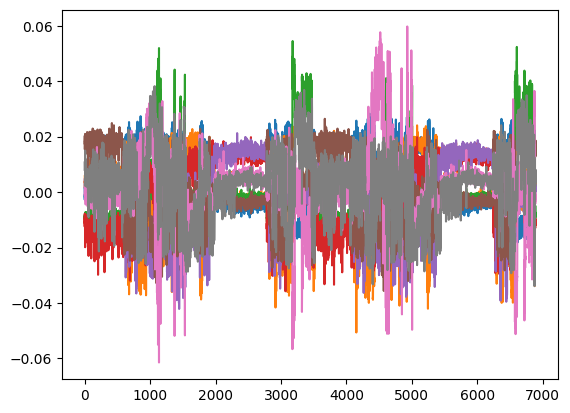

In [133]:

plt.plot(support_vectors[0, :, :].cpu(), '-')
plt.show()

In [89]:
print(incorrect_pred_list[:20])

tensor([3., 0., 0., 0., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
        0., 2.])


In [35]:
import my_code.permutation_utils as permutation_utils


pred = torch.tensor([
    [0.1, 0.9, 0.2],
    [0.4, 0.5, 0.2],
    [0.1, 0.8, 0.4],
])


pred_norm = permutation_utils.log_sinkhorn(torch.log(pred), n_iter=20)

# Check whether rows sum to 1.
assert torch.allclose(pred_norm.sum(dim=0), torch.ones(pred_norm.shape[0]))

# Check whether columns sum to 1.
assert torch.allclose(pred_norm.sum(dim=1), torch.ones(pred_norm.shape[1]))

print(pred_norm)

print(permutation_utils.matching(pred_norm))


tensor([[0.2189, 0.4773, 0.3038],
        [0.6061, 0.1836, 0.2103],
        [0.1750, 0.3392, 0.4858]])
tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1]])


## Band limited permutation matrix

In [88]:
mat_size = 8
band_size = 4

mask = torch.zeros(mat_size, mat_size)
for i in range(mat_size):
    for j in range(mat_size):
        if abs(i - j) < band_size:
            mask[i, j] = 1
            
# print(mask)

# sample random permutation matrices until we find one that satisfies the band constraint
n_iter = 0
while True:
    n_iter += 1
    perm = torch.eye(mat_size)[torch.randperm(mat_size)]
    if torch.allclose(perm * mask, perm):
        break
    
print('Number of iterations', n_iter)
print(perm)



Number of iterations 17
tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.]])


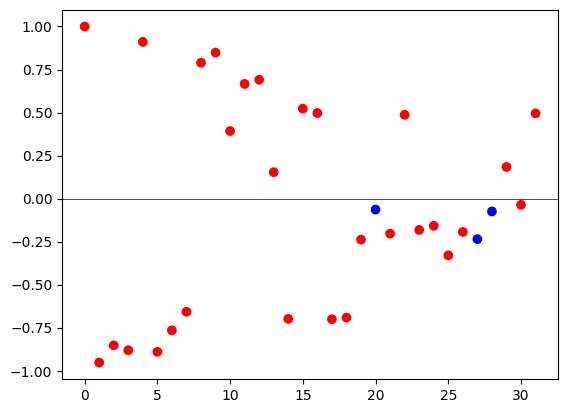

In [8]:
# plt.plot(sign_flip_gt.squeeze().detach().cpu().numpy(), '.')

# marker color = blue if incorrect, red if correct

color = np.where(sign_correct.squeeze().detach().cpu().numpy() == 1, 'red', 'blue')

plt.scatter(np.arange(feature_dim), sign_flip_predicted.squeeze().detach().cpu().numpy(), c=color)

plt.axhline(0, color='black', linewidth=0.5)
# plt.plot(sign_correct.squeeze().detach().cpu().numpy(), '.')

In [9]:
incorrect_signs_list[:20]

tensor([2., 3., 7., 2., 5., 1., 3., 3., 6., 2., 6., 6., 6., 5., 3., 5., 3., 2.,
        7., 2.])

In [11]:
evecs_flip.shape

torch.Size([1, 6890, 32])

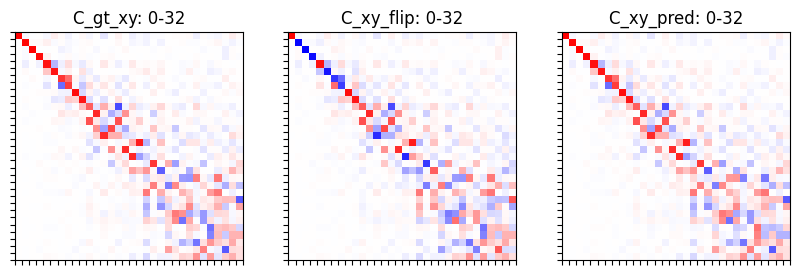

In [9]:
# evecs_orig, evecs_flip
# sign_flip_gt, sign_flip_predicted

# evecs_orig, evecs_flip * sign_flip_gt

C_gt_xy = test_shape['C_gt_xy'][0]
corr_second = test_shape['corr']
corr_first = train_dataset[0]['first']['corr']
evecs_first = train_dataset[0]['first']['evecs']


C_xy_flip = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second],
    evecs_first[corr_first]
    ).solution
C_xy_pred = torch.linalg.lstsq(
    evecs_flip.cpu()[0, corr_second] * torch.sign(sign_flip_predicted).cpu(),
    evecs_first[corr_first]
    ).solution


l = 0
h = 32


fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy, 'C_gt_xy', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_flip, 'C_xy_flip', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_xy_pred, 'C_xy_pred', l, h, show_grid=False, show_colorbar=False)

plt.show()